### backward stepwise function

In [1]:
import copy
import numpy as np
import pandas as pd
import statsmodels.api as sm

from tqdm import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

#%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [2]:
def backward_step_select(df, predictors, response):
    p = len(predictors)
    
    def process_linear_model(features):
        X = sm.add_constant(df[features])
        y = df[response]
        
        model = sm.OLS(y,X).fit()
        RSS = model.ssr

        return (model, RSS)
    
    def update_model(rest_features):
        results = []
        
        for feature in rest_features:
            rest_features_copy = copy.deepcopy(rest_features)
            rest_features_copy.remove(feature)
            results.append(process_linear_model(rest_features_copy))
            
        new_model = sorted(results, key = itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    models = []
    rest_features = predictors 

    model_all_predictors = process_linear_model(predictors)[0]
    features_all_predictors = list(model_all_predictors.params.index)[1:]
    models.append((features_all_predictors, model_all_predictors))
    
    for k in tqdm(range(p, 1, -1)): # p-1, p-2, p-3, ... ,1 
        
        new_features, new_model = update_model(rest_features)
        rest_features = new_features
        
        models.append((new_features,new_model))
        
    return models


In [3]:
df_C1 = pd.read_excel(r'.\C1.xlsx', index_col=0)
df_C2 = pd.read_excel(r'.\C2.xlsx', index_col=0)
df = pd.concat([df_C1, df_C2], axis=0)
df = df.fillna(0)
df.head()

,instance,Optimal_obj,sum_x,sum_y,mean_x,mean_y,median_x,median_y,max_x,max_y,...,Obj. Coeff. Variability,Weight of MST,Weight of Modified MST,Perimeter of Convex Hull,Area of Convex Hull,Fraction of Nodes on Convex Hull,Node Density,Hull Predictor 1,Hull Predictor 2,Hull Predictor 3
1,inst_1,363873.6000,8240,8072,257.500000,252.250000,275.5,213.0,493,490,...,17014.57196,202392.2565,334923.3556,1680.189406,198567.0,0.312500,0.000161,490557.9160,0.885990,0.777450
2,inst_2,419470.2543,10370,10905,241.162791,253.604651,272.0,280.0,495,492,...,16125.57640,219082.8790,387604.6383,1683.662601,194731.5,0.186047,0.000221,825287.3016,0.887367,0.796761
3,inst_3,410705.2870,9110,11146,222.195122,271.853658,216.0,262.0,493,495,...,15717.24733,214871.2296,376077.4329,1573.123545,181742.5,0.292683,0.000226,498234.5337,0.871206,0.722148
4,inst_4,368693.4813,8142,9653,220.054054,260.891892,192.0,287.0,493,472,...,14800.65357,188700.5419,327801.5320,1513.296703,159480.0,0.243243,0.000232,582330.8314,0.847593,0.674969
5,inst_5,303097.7173,8902,6532,287.161290,210.709677,292.0,203.0,475,430,...,12283.18677,152251.9908,259404.8230,1234.045734,112184.5,0.322581,0.000276,378673.1986,0.672041,0.418146


In [4]:
column_list = list(df.columns)
predictors = column_list[:]
predictors.remove('instance')
predictors.remove('Optimal_obj')

response = 'Optimal_obj'

models = backward_step_select(df, predictors, response)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [20:24<00:00, 10.64s/it]


['sum_x', 'sum_y', 'mean_x', 'mean_y', 'std_x', 'std_y', 'var_y', 'quantil25_y', 'quantil75_x', 'expansion_x', 'mean_distance', 'median_distance', 'shortest_distance', 'distances_sum', 'distances_var', 'sumAngles', 'minAngles', 'maxAngles', 'meanAngles', 'medianAngles', 'Angles_quantil75', 'obj_combi_min', 'obj_combi_mean', 'obj_combi_var', 'obj_combi_quantil25', 'obj_combi_quantil50', 'sumAreas', 'varAreas', 'sumRadii', 'minRadii', 'maxRadii', 'meanRadii', 'varRadii', 'Radii_quantil50', 'Radii_quantil75', 'Avr. First NN', 'Std. First NN', 'Sum. First NN', 'Var. First NN', 'Min. First NN', 'Quantil75. First NN', 'Avr. Second NN', 'Std. Second NN', 'Sum. Second NN', 'Var. Second NN', 'Avr. Third NN', 'Std. Third NN', 'Sum. Third NN', 'Var. Third NN', 'Quantil25. Third NN', 'Weight of MST', 'Weight of Modified MST', 'Perimeter of Convex Hull', 'Area of Convex Hull', 'Node Density', 'Hull Predictor 1', 'Hull Predictor 3'] 

['sum_x', 'mean_x', 'mean_distance', 'distances_sum', 'distances_

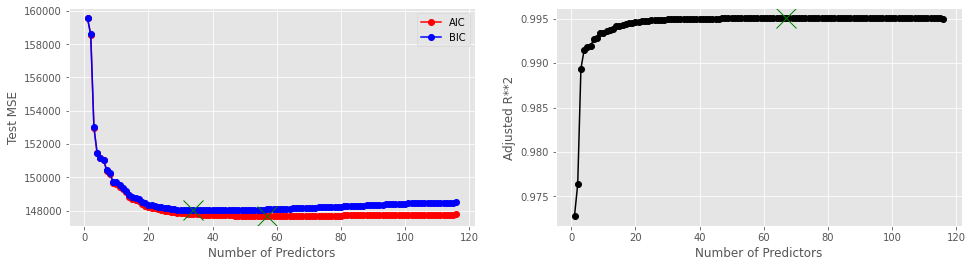

In [5]:
models.reverse()
aics = [models[x][1].aic for x in range(len(models))]
bics = [models[x][1].bic for x in range(len(models))]
r_adj = [models[x][1].rsquared_adj for x in range(len(models))]

min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

print(models[min_aic_index][0], '\n')
print(models[min_bic_index][0], '\n')
print(models[max_radj_index][0], '\n')

num_predictors = np.linspace(1,len(models),len(models))
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

plt.savefig(r'.\backward stepwise selection.png')